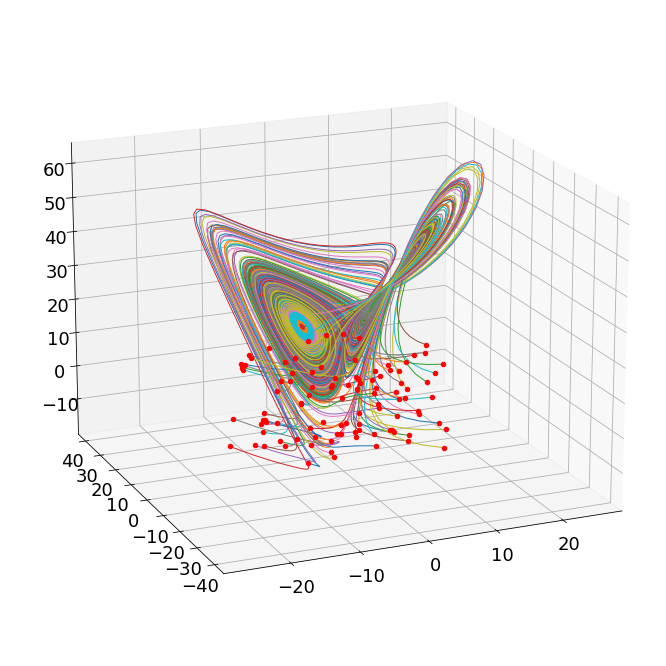

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28


nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

Epoch 1/50
2000/2000 [==============================] - 4s 2ms/step - loss: 2.8531 - val_loss: 0.0429
Epoch 2/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0223 - val_loss: 0.0290
Epoch 3/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0186 - val_loss: 0.0251
Epoch 4/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0159 - val_loss: 0.0220
Epoch 5/50
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 6/50
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0124 - val_loss: 0.0172
Epoch 7/50
2000/2000 [==============================] - 2s 941us/step - loss: 0.0108 - val_loss: 0.0139
Epoch 8/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0096 - val_loss: 0.0168
Epoch 9/50
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0090 - val_loss: 0.0119
Epoch 10/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0

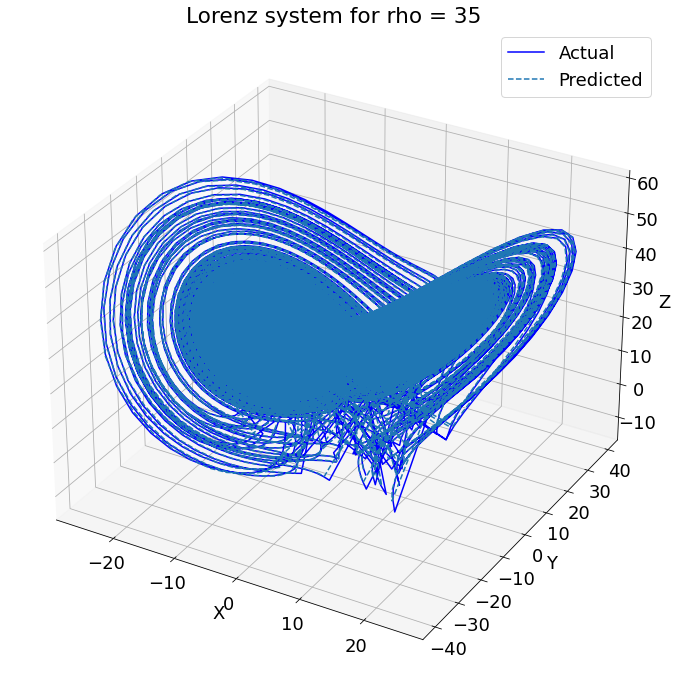

In [2]:
# Define function to generate training data
def generate_data(rho, n_samples=100):
    np.random.seed(123)
    x0 = -15 + 30 * np.random.random((n_samples, 3))
    x_t = np.asarray([odeint(lorenz_deriv, x0_j, t) for x0_j in x0])
    x = x_t[:, :-1, :]
    y = x_t[:, 1:, :]
    return x.reshape(-1, 3), y.reshape(-1, 3)

# Create NN model
model = Sequential()
model.add(Dense(64, input_dim=3, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model for rho = 10
rho = 10
x_train, y_train = generate_data(rho)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Train the model for rho = 28
rho = 28
x_train, y_train = generate_data(rho)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Train the model for rho = 40
rho = 40
x_train, y_train = generate_data(rho)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)



2500/2500 [==============================] - 2s 713us/step


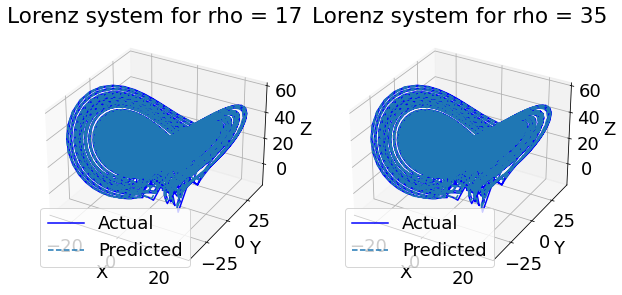

In [7]:
# Evaluate the model for rho values of 17 and 35
fig = plt.figure(figsize=(10, 10))
for i, rho in enumerate([17, 35]):
    x_test, y_test = generate_data(rho)
    y_pred = model.predict(x_test)

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'b', label='Actual')
    ax.plot(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], '--', label='Predicted')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Lorenz system for rho = {rho}')
    ax.legend()

plt.show()

In [8]:
def generate_data(x_t, dt, rho_values):
    X = []
    y = []
    for i, rho in enumerate(rho_values):
        for j in range(x_t.shape[0]):
            for k in range(1, x_t.shape[1]):
                if k < len(t)-1:
                    X.append(np.hstack((x_t[j,k,:], rho)))
                    y.append(x_t[j,k+1,:])
    X = np.array(X)
    y = np.array(y)
    return X, y

rho_values = [10, 28, 40]
X_train, y_train = generate_data(x_t, dt, rho_values)


In [9]:
# LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(4, 1)))
model_lstm.add(Dense(3))

# Compile the model
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Reshape the training data to match the input shape of the LSTM model
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Train the LSTM model
model_lstm.fit(X_train_lstm, y_train, epochs=100, batch_size=64)


Epoch 1/100
3746/3746 [==============================] - 18s 4ms/step - loss: 5.9355
Epoch 2/100
3746/3746 [==============================] - 17s 5ms/step - loss: 0.0280
Epoch 3/100
3746/3746 [==============================] - 28s 7ms/step - loss: 0.0115
Epoch 4/100
3746/3746 [==============================] - 16s 4ms/step - loss: 0.0083
Epoch 5/100
3746/3746 [==============================] - 19s 5ms/step - loss: 0.0078
Epoch 6/100
3746/3746 [==============================] - 18s 5ms/step - loss: 0.0065
Epoch 7/100
3746/3746 [==============================] - 21s 6ms/step - loss: 0.0061
Epoch 8/100
3746/3746 [==============================] - 17s 5ms/step - loss: 0.0051
Epoch 9/100
3746/3746 [==============================] - 20s 5ms/step - loss: 0.0053
Epoch 10/100
3746/3746 [==============================] - 19s 5ms/step - loss: 0.0047
Epoch 11/100
3746/3746 [==============================] - 19s 5ms/step - loss: 0.0047
Epoch 12/100
3746/3746 [==============================] - 19s 5

In [10]:
# RNN
# Define the RNN model
model_rnn = Sequential()
model_rnn.add(Dense(128, input_shape=(4,)))
model_rnn.add(Dense(3))

# Compile the model
model_rnn.compile(loss='mean_squared_error', optimizer='adam')

# Train the RNN model
model_rnn.fit(X_train, y_train, epochs=100, batch_size=64)


Epoch 1/100
3746/3746 [==============================] - 4s 911us/step - loss: 1.1572
Epoch 2/100
3746/3746 [==============================] - 4s 955us/step - loss: 0.3281
Epoch 3/100
3746/3746 [==============================] - 3s 905us/step - loss: 0.3275
Epoch 4/100
3746/3746 [==============================] - 4s 956us/step - loss: 0.3266
Epoch 5/100
3746/3746 [==============================] - 3s 882us/step - loss: 0.3242
Epoch 6/100
3746/3746 [==============================] - 3s 866us/step - loss: 0.3212
Epoch 7/100
3746/3746 [==============================] - 4s 1ms/step - loss: 0.3202
Epoch 8/100
3746/3746 [==============================] - 3s 932us/step - loss: 0.3191
Epoch 9/100
3746/3746 [==============================] - 3s 890us/step - loss: 0.3177
Epoch 10/100
3746/3746 [==============================] - 4s 1ms/step - loss: 0.3173
Epoch 11/100
3746/3746 [==============================] - 3s 828us/step - loss: 0.3159
Epoch 12/100
3746/3746 [==============================] 

In [11]:
from sklearn.metrics import mean_squared_error

x0_test = -15 + 30 * np.random.random((100, 3))
rho_test = [17, 35]
x_t_test = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0_test])
X_test, y_test = generate_data(x_t_test, dt, rho_test)

# Reshape the test data to match the input shape of the LSTM model
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Use the trained LSTM model to make predictions on the test data
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Use the trained RNN model to make predictions on the test data
y_pred_rnn = model_rnn.predict(X_test)

# Calculate the mean squared error for the LSTM model
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print('LSTM MSE:', mse_lstm)

# Calculate the mean squared error for the RNN model
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
print('RNN MSE:', mse_rnn)


4994/4994 [==============================] - 3s 597us/step
LSTM MSE: 0.0031942127091748097
RNN MSE: 0.3095720377747974
